In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def my_func(idx, arr):
    if idx in (8, 17, 26, 35, 44, 53, 62, 71, 80) or idx > 70:
        return None
    return arr[idx + 10]
# Load image, grayscale, median blur, sharpen image
image = cv2.imread('example2.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Calculate the median pixel value
med_val = np.median(image) 


# blur = cv2.bilateralFilter(gray, 9, 150, 150)
# blur = cv2.medianBlur(gray, 5)
blur = cv2.GaussianBlur(gray, (5,5), 0)
# sharpen = cv2.addWeighted(blur, 1.5, blur, -0.6, 0)
sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
# sharpen = cv2.filter2D(blur, -1, sharpen_kernel)
canny = cv2.Canny(blur, 100, 100)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))

# laplace = cv2.Laplacian(blur, cv2.CV_16S, ksize=3)
# abs_laplace = cv2.convertScaleAbs(laplace)

# Sobel
# sobelx = cv2.Sobel(blur, cv2.CV_16S, 1, 0, ksize=3)
# sobely = cv2.Sobel(blur, cv2.CV_16S, 0, 1, ksize=3)
# abs_sobelx = cv2.convertScaleAbs(sobelx)
# abs_sobely = cv2.convertScaleAbs(sobely)
# sobel = cv2.addWeighted(abs_sobelx, 0.5, abs_sobely, 0.5, 0)
# sobel = cv2.GaussianBlur(sobel, (5,5), 0)
# sobel = cv2.morphologyEx(sobel, cv2.MORPH_CLOSE, kernel, iterations=2)
# sobel = cv2.erode(sobel, kernel, iterations=1)
# sobel = cv2.filter2D(sobel, -1, sharpen_kernel)
# sobel = cv2.GaussianBlur(sobel, (3,3), 0)
# sobel = cv2.threshold(sobel, 120, 240, cv2.THRESH_BINARY_INV)[1]
# sobel = cv2.morphologyEx(sobel, cv2.MORPH_OPEN, kernel, iterations=1)
# sobel = cv2.GaussianBlur(sobel, (5,5), 0)

equ = cv2.equalizeHist(gray)
equ = cv2.GaussianBlur(equ, (9,9), 0)
equ = cv2.Canny(equ, 100, 100)
equ = cv2.dilate(equ, kernel, iterations=1)


# Threshold and morph close
dillation = cv2.dilate(canny, kernel, iterations=2)
erode = cv2.erode(dillation, kernel, iterations=1)
thresh = cv2.threshold(erode, 210, 240, cv2.THRESH_BINARY_INV)[1]
thresh = cv2.GaussianBlur(thresh, (5,5), 0)

opening = cv2.morphologyEx(dillation, cv2.MORPH_OPEN, kernel, iterations=1)

close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)
close = cv2.erode(close, kernel, iterations=1)
close = cv2.dilate(close, kernel, iterations=2)
close = cv2.Canny(close, 100, 100)
close = cv2.dilate(close, kernel, iterations=1)
close = cv2.GaussianBlur(close, (7,7), 0)
close = cv2.filter2D(close, -1, sharpen_kernel)

# Find contours and filter using threshold area
cnts = cv2.findContours(close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

min_area = 100
max_area = 1500
image_number = 0
for c in cnts:
    area = cv2.contourArea(c)
    if area > min_area and area < max_area:
        x,y,w,h = cv2.boundingRect(c)
        ROI = image[y:y+h, x:x+w]
        #cv2.imwrite('ROI_{}.png'.format(image_number), ROI)
        cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)
        image_number += 1

# Find lines
lines = cv2.HoughLines(close, 2, np.pi / 180, 600, None, 0, 0)
# Draw the lines
good_lines = {
    'horizontal': [],
    'vertical': []
}
if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        angle = np.arctan2(y0, x0) * 180.0 / np.pi
        # Draw only vertical and horizontal lines
        if not (abs(angle) < 89.5 or abs(angle) > 90.5):
            pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
            pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
            cv2.line(image, pt1, pt2, (0,0,255), 1, cv2.LINE_AA)
            good_lines['vertical'].append((pt1, pt2))
        if not (abs(angle) < 0.5 or abs(angle) > 1.5):
            pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
            pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
            cv2.line(image, pt1, pt2, (0,0,255), 1, cv2.LINE_AA)
            good_lines['horizontal'].append((pt1, pt2))

# Draw circles on the intersections
intersection_points = []
for h in good_lines['horizontal']:
    for v in good_lines['vertical']:
        x = (h[0][0] * h[1][1] - h[0][1] * h[1][0]) * (v[0][0] - v[1][0]) - (h[0][0] - h[1][0]) * (v[0][0] * v[1][1] - v[0][1] * v[1][0])
        x /= (h[0][0] - h[1][0]) * (v[0][1] - v[1][1]) - (h[0][1] - h[1][1]) * (v[0][0] - v[1][0])
        y = (h[0][0] * h[1][1] - h[0][1] * h[1][0]) * (v[0][1] - v[1][1]) - (h[0][1] - h[1][1]) * (v[0][0] * v[1][1] - v[0][1] * v[1][0])
        y /= (h[0][0] - h[1][0]) * (v[0][1] - v[1][1]) - (h[0][1] - h[1][1]) * (v[0][0] - v[1][0])
        intersection_points.append((x, y))
        # cv2.circle(image, (int(x), int(y)), 5, (255,0,0), -1)


# Merge neighboring points
points = []
for p in intersection_points:
    if len(points) == 0:
        points.append(p)
    else:
        found = False
        for i in range(0, len(points)):
            if abs(points[i][0] - p[0]) < 20 and abs(points[i][1] - p[1]) < 12:
                points[i] = ((points[i][0] + p[0]) / 2, (points[i][1] + p[1]) / 2)
                found = True
                break
        if not found:
            points.append(p)

# Sort points
points = sorted(points, key=lambda x: x[0])
points = sorted(points, key=lambda x: x[1])

assert len(points) == 81, 'Expected 81 points, got {}'.format(len(points))
squares = []
for i, point in enumerate(points):
    pt1 = point
    pt2 = my_func(i, points)
    if pt2 is not None:
        squares.append((pt1, pt2))

# Save the squares
for i, square in enumerate(squares):
    x1 = int(square[0][0])
    y1 = int(square[0][1])
    x2 = int(square[1][0])
    y2 = int(square[1][1])
    cv2.imwrite('squares/ROI_{}.png'.format(i), image[y1:y2, x1:x2])


# Draw the points
for p in points:
    cv2.circle(image, (int(p[0]), int(p[1])), 5, (255,0,0), -1)


# Probabilistic Line Transform
linesP = cv2.HoughLinesP(close, 1, np.pi / 180, 500, None, 50, 10)
# Draw the lines
if linesP is not None:
    for i in range(0, len(linesP)):
        angle = np.arctan2(linesP[i][0][1] - linesP[i][0][3], linesP[i][0][0] - linesP[i][0][2]) * 180.0 / np.pi
        if abs(angle) < 93 or abs(angle) > 97:
            continue
        l = linesP[i][0]
        cv2.line(image, (l[0], l[1]), (l[2], l[3]), (0,255,0), 1, cv2.LINE_AA)

cv2.imshow('dillation', dillation)
cv2.imshow('canny', canny)
cv2.imshow('close', close)
cv2.imshow('equ', equ)
cv2.imshow('thresh', thresh)
cv2.imshow('image', image)
cv2.waitKey()

In [ ]:
points_test = [
    0,   1,   2,   3,   4,   5,   6,   7,   8,
    9,   10,  11,  12,  13,  14,  15,  16,  17,
    18,  19,  20,  21,  22,  23,  24,  25,  26,
    27,  28,  29,  30,  31,  32,  33,  34,  35,
    36,  37,  38,  39,  40,  41,  42,  43,  44,
    45,  46,  47,  48,  49,  50,  51,  52,  53,
    54,  55,  56,  57,  58,  59,  60,  61,  62,
    63,  64,  65,  66,  67,  68,  69,  70,  71,
    72,  73,  74,  75,  76,  77,  78,  79,  80,
]
points_test = np.array(points_test)
def my_func(idx):
    if idx in (8, 17, 26, 35, 44, 53, 62, 71, 80) or idx > 70:
        return None
    return points_test[idx + 10]

assert my_func(0) == 10
assert my_func(1) == 11
assert my_func(7) == 17
assert my_func(8) == None
assert my_func(72) == None
assert my_func(71) == None


<Figure size 640x480 with 0 Axes>

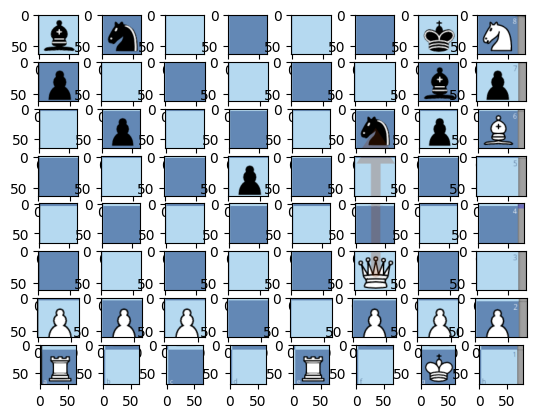

In [29]:
import os

def load_images_from_folder(folder):
    images = []
    file_names = sorted(os.listdir(folder), key= lambda x: int(x.split('_')[1].split('.')[0]))
    # print(file_names)
    for filename in file_names:
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)

    return images

images = load_images_from_folder('squares')
image1 = cv2.imread('squares/ROI_0.png')
# all_images = np.concatenate(images, axis=1)
detector = SquareDetector()
squares_new = detector.detect('1.png')

plt.figure()

f, axarr = plt.subplots(8, 8)
for i in range(0, 8):
    for j in range(0, 8):
        axarr[i, j].imshow(squares_new[i * 8 + j])

plt.show()

In [28]:
class SquareDetector():

    
    def __init__(self, mode=0, line_v_err=0.5, line_h_err=0.5, p_merge_trshx=20, p_merge_trshy=12) -> None:
        self.mode = {
            0: 'v1',
            1: 'v2',
        }[mode]
        self._kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
        self._kernel_sharpen = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
        self._lines_threshold = 600
        self._lines = {
            'horizontal': [],
            'vertical': [],
        }
        self._lines_vertical_error = line_h_err
        self._lines_horizontal_error = line_v_err
        self._points_merge_threshold_x = p_merge_trshx
        self._points_merge_threshold_y = p_merge_trshy

    def _crop_squares_from_image(self, image, squares) -> list:
        cropped_squares = []
        for i, square in enumerate(squares):
            x1 = int(square[0][0])
            y1 = int(square[0][1])
            x2 = int(square[1][0])
            y2 = int(square[1][1])
            cropped_squares.append(image[y1:y2, x1:x2])
        return cropped_squares

    def _create_squares(self, points) -> list:
        assert len(points) == 81, 'Expected 81 points, got {}\nTry to change the merge threshold'.format(len(points))
        squares = []
        for i, point in enumerate(points):
            pt1 = point
            pt2 = None if i in (8, 17, 26, 35, 44, 53, 62, 71, 80) or i > 70 else points[i + 10]
            if pt2 is not None:
                squares.append((pt1, pt2))
        return squares

    def _load_image(self, path):
        image = cv2.imread(path)
        return image

    def _merge_neighbouring_points(self, points):
        """
        Merge neighbouring points
        """
        points_merged = []
        for p in points:
            if len(points) == 0:
                points_merged.append(p)
            else:
                found = False
                for i in range(0, len(points_merged)):
                    if (abs(points_merged[i][0] - p[0]) < self._points_merge_threshold_x and abs(points_merged[i][1] - p[1]) < self._points_merge_threshold_y):
                        points_merged[i] = ((points_merged[i][0] + p[0]) / 2,
                                            (points_merged[i][1] + p[1]) / 2)
                        found = True
                        break
                if not found:
                    points_merged.append(p)
        # Sort points
        points_merged = sorted(points_merged, key=lambda x: x[0])
        points_merged = sorted(points_merged, key=lambda x: x[1])
        return points_merged

    def _calculate_intersection_points(self) -> list:
        """
        Calculate the intersection points of all the lines
        """
        intersection_points = []
        for h in self._lines['horizontal']:
            for v in self._lines['vertical']:
                # https://stackoverflow.com/questions/20677795/how-do-i-compute-the-intersection-point-of-two-lines
                x = (h[0][0] * h[1][1] - h[0][1] * h[1][0]) * (v[0][0] - v[1][0]) - (h[0][0] - h[1][0]) * (v[0][0] * v[1][1] - v[0][1] * v[1][0])
                x /= (h[0][0] - h[1][0]) * (v[0][1] - v[1][1]) - (h[0][1] - h[1][1]) * (v[0][0] - v[1][0])
                y = (h[0][0] * h[1][1] - h[0][1] * h[1][0]) * (v[0][1] - v[1][1]) - (h[0][1] - h[1][1]) * (v[0][0] * v[1][1] - v[0][1] * v[1][0])
                y /= (h[0][0] - h[1][0]) * (v[0][1] - v[1][1]) - (h[0][1] - h[1][1]) * (v[0][0] - v[1][0])
                intersection_points.append((x, y))
        return intersection_points

    def _detec_lines_v2(self, image):
        pass

    def _detec_lines_v1(self, image):
        lines = cv2.HoughLines(image, 2, np.pi / 180, self._lines_threshold, None, 0, 0)
        if lines is None:
            raise Exception('No lines detected')

        for i in range(0, len(lines)):
            rho = lines[i][0][0]
            theta = lines[i][0][1]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            angle = np.arctan2(y0, x0) * 180.0 / np.pi

            pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
            pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))

            if not (abs(angle) < (90-self._lines_vertical_error) or
                abs(angle) > (90+self._lines_vertical_error)):
                self._lines['vertical'].append((pt1, pt2))
            elif not ((abs(angle) < (self._lines_horizontal_error)) or
                (abs(angle) < 0.5 or abs(angle) > 1.5)): # Not sure if this is correct
                self._lines['horizontal'].append((pt1, pt2))

    def _detec_lines(self, image):
        if self.mode == 'v1':
            return self._detec_lines_v1(image)
        elif self.mode == 'v2':
            return self._detec_lines_v2(image)

    def _process_image_v2(self, image):
        pass

    def _process_image_v1(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (5,5), 0)
        canny = cv2.Canny(blur, 100, 100)
        dillation = cv2.dilate(canny, self._kernel, iterations=2)
        erode = cv2.erode(dillation, self._kernel, iterations=1)
        _, thresh = cv2.threshold(erode, 210, 240, cv2.THRESH_BINARY_INV)
        thresh = cv2.GaussianBlur(thresh, (5,5), 0)
        close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, self._kernel, iterations=1)
        close = cv2.erode(close, self._kernel, iterations=1)
        close = cv2.dilate(close, self._kernel, iterations=2)
        close = cv2.Canny(close, 100, 100)
        close = cv2.dilate(close, self._kernel, iterations=1)
        close = cv2.GaussianBlur(close, (7,7), 0)
        close = cv2.filter2D(close, -1, self._kernel_sharpen)
        return close

    def _process_image(self, image):
        if self.mode == 'v1':
            return self._process_image_v1(image)
        elif self.mode == 'v2':
            return self._process_image_v2(image)

    def detect(self, image_path) -> list:
        """
        Detect the squares in the image of chessboard
        """
        image = self._load_image(image_path)
        image_processed = self._process_image(image)
        self._detec_lines(image_processed)
        points = self._calculate_intersection_points()
        points = self._merge_neighbouring_points(points)
        squares = self._create_squares(points)
        cropped_squares = self._crop_squares_from_image(image, squares)
        return cropped_squares